# Loading data & time conversion

## Load activity labels data

In the TrainActivities.csv, all time-related columns are in JST but doesn't contain UTC information. 

While all accelerometer data are took in different time zones. 

Thus we need to add UTC information to activity labels dataset which is UTC+09:00

And convert all accelerometer data into the same timezone which is UTC+09:00

In [1]:
import pandas as pd
# load activity data
act_df = pd.read_csv('../data/TrainingDataPD25/TrainActivities.csv')
act_df.head()

,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024/09/02 6:16,2024/09/02 6:16,2024/09/02 6:16,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:17,2024/09/02 6:17,2024/09/02 6:17,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:18,2024/09/02 6:18,2024/09/02 6:18,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024/09/02 6:20,2024/09/02 6:20,2024/09/02 6:20,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024/09/02 6:42,2024/09/02 6:42,2024/09/02 6:42,U2


In [2]:
def convert_to_jst(df, columns):
    """ Converting time-domain columns into datetime format in pandas DataFrame 
    Return:
        tmp_df: a copy of original DataFrame with time-domain columns were converted to datetime format
    Args:
        df: DataFrame used to convert
        columns: time-domain columns
    Usages:
        cols = ['Started', 'Finished', 'Updated']
        act_df = convert_to_jst(act_df, cols)
    """
    tmp_df = df.copy()
    for col in columns:
        tmp_df[col] = pd.to_datetime(tmp_df[col], format='%Y/%m/%d %H:%M', errors='coerce')
        tmp_df[col] = tmp_df[col].dt.tz_localize('UTC+09:00')
    return tmp_df

cols = ['Started', 'Finished', 'Updated']
act_df = convert_to_jst(act_df, cols)

In [3]:
print(f'Started: {act_df['Started'].dt.tz}')
print(f'Finished: {act_df['Finished'].dt.tz}')
print(f'Updated: {act_df['Updated'].dt.tz}')
display(act_df.head())

Started: UTC+09:00
Finished: UTC+09:00
Updated: UTC+09:00


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2


## Load users acceleration data
This dataset contains more than one timezones, and all of them include the UTC offset.

In [4]:
# Load all csv files into one dataframe
import os
import glob
from datetime import timezone, timedelta

base_dir = '/Users/tptn/MachineLearning/tremor_challenge2/data/TrainingDataPD25/users_timeXYZ/users'
headers = ['id', 'datetime', 'x', 'y', 'z']

def read_users_df(base_dir, headers):
    """ Read all csv files in users folder 
    Return:
        users_df: a DataFrame contains all csv files
    Args:
        base_dir: base folder to csv files
        headers: headers for csv files
    """
    df_list = [] # to store all csv files
    for id in os.listdir(base_dir):
        path = os.path.join(base_dir, id)

        if os.path.isdir(path):
            files = glob.glob(os.path.join(path, '*.csv'))

            for f in files:
                df = pd.read_csv(f, header=None, names=headers) # load csv
                df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z') # conver to datetime
                tz = df['datetime'].dt.tz # get the timezone
                if tz != 'UTC+09:00':
                    df['datetime'] = df['datetime'].dt.tz_convert('UTC+09:00')
                df_list.append(df)
    users_df = pd.concat(df_list, ignore_index=True)
    return users_df

users_df = read_users_df(base_dir, headers)

In [5]:
# check if there is different timezone in datetime column
unique_timezones = users_df['datetime'].apply(lambda x: x.tz).unique()
print(unique_timezones)

[datetime.timezone(datetime.timedelta(seconds=32400))]


From the above result, we can know that the acceleration data is successfully read and converted to JST

# Explore the data
## Plot each activity count per user id

Before drop na and duplicated


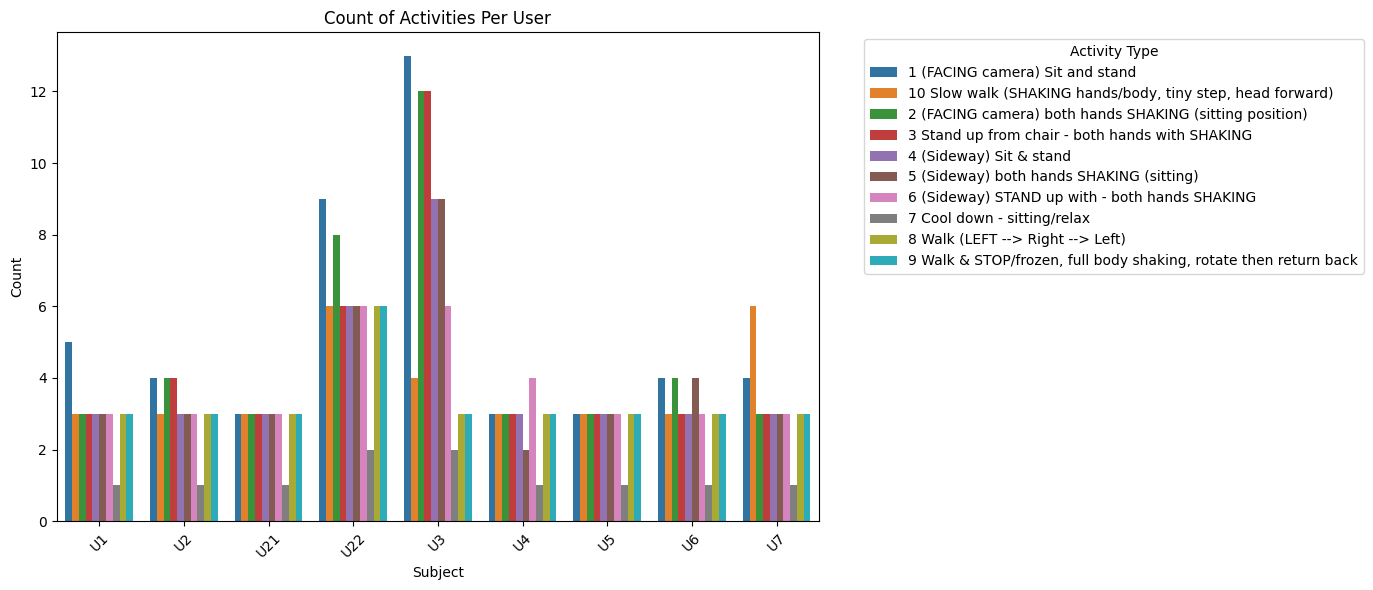

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_act_count_per_user(df, group_order=['Subject', 'Activity Type']):
    # Group by Subject and Activity Type, then count occurrences
    activity_counts = df.groupby(group_order).size().reset_index(name='Count')

    # Plot
    plt.figure(figsize=(14, 6))
    sns.barplot(data=activity_counts, x='Subject', y='Count', hue='Activity Type')
    plt.title('Count of Activities Per User')
    plt.xticks(rotation=45)
    plt.legend(title='Activity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print('Before drop na and duplicated')
plot_act_count_per_user(act_df)

**Drop na and duplicated in activity labels data**

In [10]:
# Clean up the dataset
print('number of na rows per columns:')
print(act_df.isna().sum())
cols = ['Activity Type', 'Started', 'Finished']
print(f'number of duplicated activity rows: {act_df.duplicated(subset=cols, keep='last').sum()}')
print(f'act_df shape: {act_df.shape}')

number of na rows per columns:
ID                   0
Activity Type ID     0
Activity Type        0
Started             66
Finished            67
Updated              0
Subject              0
dtype: int64
number of duplicated activity rows: 128
act_df shape: (342, 7)


From the above result, we can see that this dataset have
- 66 na values in Started
- 67 na values in Finished
- 128 duplicated started-finished-activity_type rows.

In [14]:
def drop_rows(df, drop_dup=False):
    """ Drop na and duplicated row then sort 
    
    Return:
        drop_df: Dropped and sorted DataFrame

    Args;
        df: DataFrame to be dropped
        drop_dup: if true, drop duplicated rows
    """
    drop_df = df.dropna() # drop na
    
    # drop duplicated rows
    cols = ['Activity Type', 'Started', 'Finished']
    if (drop_dup):
        drop_df = drop_df.drop_duplicates(subset=cols, keep='last')
    
    # sorting
    sort_order = ['Started']
    drop_df = drop_df.sort_values(by=sort_order)

    drop_df = drop_df.reset_index(drop=True)

    return drop_df

dropped_act_df = drop_rows(act_df, drop_dup=False)
print(f'act_df shape: {dropped_act_df.shape}')
display(dropped_act_df.head())

act_df shape: (275, 7)


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2


In [ ]:
plot_act_count_per_user(act_df, )

# Matching activity labels with sensor data

In order to match the activity labels with the sensor data, we need to consider whether the timestamps in the sensor data are in the started and finished time of the activity or not. However, the started and finished in activity labels dataset do not contain any seconds, which makes no interval exists between started and finished.

Solution:
- Assume a activity started at H:min:00.000000 and finished at H:min:59.999999

In [21]:
act_df['started'] = act_df['Started'].dt.floor('s')
act_df['finished'] = act_df['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)

In [23]:
cols = ['Started', 'started', 'Finished', 'finished']
act_df[cols].head()

,Started,started,Finished,finished
0,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:59.999999+09:00
1,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:59.999999+09:00
2,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:59.999999+09:00
3,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:59.999999+09:00
4,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00


number of na rows per columns:


ID                   0
Activity Type ID     0
Activity Type        0
Started             66
Finished            67
Updated              0
Subject              0
started             66
finished            67
dtype: int64

number of duplicated activity rows: 128
act_df shape: (342, 9)


act_df shape: (203, 9)


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject,started,finished
0,1130306,2806,1 (FACING camera) Sit and stand,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,U1,2024-09-02 06:44:00+09:00,2024-09-02 06:44:59.999999+09:00
1,1137246,2806,1 (FACING camera) Sit and stand,2024-09-03 21:21:00+09:00,2024-09-03 21:21:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:21:00+09:00,2024-09-03 21:21:59.999999+09:00
2,1137278,2806,1 (FACING camera) Sit and stand,2024-09-03 21:22:00+09:00,2024-09-03 21:22:00+09:00,2024-09-03 21:38:00+09:00,U1,2024-09-03 21:22:00+09:00,2024-09-03 21:22:59.999999+09:00
3,1137252,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-03 21:23:00+09:00,2024-09-03 21:23:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:23:00+09:00,2024-09-03 21:23:59.999999+09:00
4,1137255,2808,3 Stand up from chair - both hands with SHAKING,2024-09-03 21:24:00+09:00,2024-09-03 21:24:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:24:00+09:00,2024-09-03 21:24:59.999999+09:00


In [29]:

from datetime import timedelta

def seg_df_per_act(users_df, act_df):
    """
    Segmenting the dataset into one dataframe per activity
    Description:
        Each activity will has its own dataframe, which contains all the timestamps and accelerometer data within the activity time range.

    Return:
        seg_list: list of df, one df contains acceleration data of corresponding activity label
        seg_label_list: list of label. one label correspond to one df in seg_list
    
    Args:
        users_df: one big DataFrame of acceleration data
        act_df: activity labels DataFrame
    """

    seg_label_list = []
    seg_list = []
    
    for i in range(0, len(act_df)):
        started_at = act_df.iloc[i]['started']
        finished_at = act_df.iloc[i]['finished']
        seg = users_df[(users_df['datetime'] >= started_at) & (users_df['datetime'] <= finished_at)]
        # seg_label = act_df.iloc[i]['Activity Type']
        seg_label = act_df.iloc[i]['Activity Type ID']
        # check if seq is not empty
        if len(seg) != 0:
            seg_list.append(seg)
            seg_label_list.append(seg_label)

    return seg_list, seg_label_list

seg_list, seg_label_list = seg_df_per_act(users_df, act_df)

In [30]:
print(f'seg_list: {len(seg_list)}, seg_label_list: {len(seg_label_list)}')

seg_list: 199, seg_label_list: 199


# Feature Extraction

In [22]:
# print(f'Started date: {act_df['Started'].dt.date.min()}')
# print(f'Finished date: {act_df['Started'].dt.date.max()}')

From the above results, we can know that the year and month values are not important. So that, we can extract the date only then drop year and month

In [23]:
# tmp_df = act_df.copy()
# tmp_df['date'] = tmp_df['Started'].dt.hour
# tmp_df.sort_values(inplace=True, by='date', ignore_index=True)
# tmp_df['date']

In [31]:
import numpy as np
from scipy.stats import iqr, skew, kurtosis

def zero_crossing_rate(signal):
    """Calculate zero crossing rate of a 1D numpy array"""
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

def safe_corr(a, b):
    """Safely calculate correlation"""
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return 0.0  # or np.nan if you prefer to filter later
    return np.corrcoef(a, b)[0, 1]

def get_feats(df, columns=['x', 'y', 'z']):
    """
    Extracting features from accelerometer data of each activity.

    Returns:
        feats: List of features (example: std_x, std_y, std_z, mean_x, ...)
    Args:
        df: dataframe
        columns: the accelerometer data
    Usages:
        feats_list = []
        for df in seg_list:
            feats_list.append(get_feats(df))
    """

    feats = []

    # Time domain features per axis
    for col in columns:
        data = df[col].values

        std_ = np.std(data, ddof=0)
        mean_ = np.mean(data)
        max_ = np.max(data)
        min_ = np.min(data)
        median_ = np.median(data)
        iqr_ = iqr(data)
        var_ = np.var(data)
        skew_ = skew(data)
        kurt_ = kurtosis(data)
        ptp_ = np.ptp(data)  # peak-to-peak (max - min)
        rms_ = np.sqrt(np.mean(data**2))
        zcr_ = zero_crossing_rate(data)

        feats.extend([
            std_, mean_, max_, min_, median_, iqr_,
            var_, skew_, kurt_, ptp_, rms_, zcr_
        ])

    # Signal Magnitude Area (SMA)
    mag = np.abs(df[columns]).sum(axis=1)
    sma = mag.sum() / len(df)
    feats.append(sma)

    # Correlation between axes
    # corr_xy = df['x'].corr(df['y'])
    # corr_yz = df['y'].corr(df['z'])
    # corr_zx = df['z'].corr(df['x'])
    corr_xy = safe_corr(df['x'], df['y'])
    corr_yz = safe_corr(df['y'], df['z'])
    corr_zx = safe_corr(df['z'], df['x'])
    
    feats.extend([corr_xy, corr_yz, corr_zx])

    return feats

In [25]:
# feats_list = []
# for df in seg_list:
#     feats_list.append(get_feats(df))

In [26]:
# print(f'feats_list: {np.array(feats_list).shape}')

## Segmentation using window sliding method

In [32]:
#TODO: convert seg_list and seg_label_list into one dataframe
"""
Segment using sliding window method

Args:
    df: accelerometer data + activity label data
    wsize: window size [seconds]
    stride: how much the window slide
"""
def windowSeg(df, wsize, stride):
    features_list = []
    start_time = df['datetime'].min()
    end_time = df['datetime'].max()
    current_start = start_time

    while current_start + pd.Timedelta(seconds=wsize) <= end_time:
        current_end = current_start + pd.Timedelta(seconds=wsize)
        window = df[(df['datetime'] >= current_start) & (df['datetime'] < current_end)]
        if not window.empty:
            feats = get_feats(window)
            features_list.append(feats)
        current_start += pd.Timedelta(seconds=stride)

    return features_list

In [33]:
def process_segments(seg_list, seg_label_list, wsize=1, stride=0.5):
    all_features = []
    all_labels = []

    for df, label in zip(seg_list, seg_label_list):
        feats_list = windowSeg(df, wsize, stride)
        all_features.extend(feats_list)
        all_labels.extend([label] * len(feats_list))

    # Define feature names for columns
    base_features = ['std', 'mean', 'max', 'min', 'median', 'iqr', 'var', 'skew', 'kurt', 'ptp', 'rms', 'zcr']
    columns = [f'{stat}_{axis}' for axis in ['x', 'y', 'z'] for stat in base_features]
    columns += ['sma', 'corr_xy', 'corr_yz', 'corr_zx']

    features_df = pd.DataFrame(all_features, columns=columns)
    features_df['label'] = all_labels

    return features_df

In [34]:
WINDOW_SIZE = 1 # window size = 1s
OVERLAP_RATE = 0.5 * WINDOW_SIZE # overlap 50% window size

all_in_one_df = process_segments(seg_list, seg_label_list, wsize=WINDOW_SIZE, stride=WINDOW_SIZE - OVERLAP_RATE)

In [209]:
print(all_in_one_df.shape)
print(all_in_one_df.isna().sum().sum())
all_in_one_df.dropna(inplace=True)
print(all_in_one_df.isna().sum().sum())

(31759, 41)
6
0


In [197]:
all_in_one_df.head(10)

,std_x,mean_x,max_x,min_x,median_x,iqr_x,var_x,skew_x,kurt_x,ptp_x,...,skew_z,kurt_z,ptp_z,rms_z,zcr_z,sma,corr_xy,corr_yz,corr_zx,label
0,2.120182,-1.746200,3.244,-3.595,-2.6620,2.179,4.495171,1.217257,0.140763,6.839,...,1.555918,2.912725,2.601,8.306923,0.0,15.143486,-0.621579,-0.586509,0.664657,2806
1,1.530195,0.384273,3.244,-1.678,0.0790,2.697,2.341496,0.311338,-1.294935,4.922,...,1.915507,5.172328,2.155,8.769498,0.0,14.160545,0.057387,-0.177057,0.083392,2806
2,0.735386,-1.259833,-0.464,-2.829,-1.0215,0.841,0.540792,-0.940182,-0.586856,2.365,...,-1.115886,1.241758,1.005,8.744610,0.0,14.058028,0.690062,-0.533574,-0.041999,2806
3,1.064116,-1.315162,1.025,-4.563,-1.0070,1.193,1.132344,-0.893106,1.079433,5.588,...,1.099830,2.756736,2.931,8.829206,0.0,14.018703,0.769648,-0.556956,-0.292193,2806
4,1.321938,-3.601943,0.026,-4.991,-4.1100,1.469,1.747521,1.408207,1.124463,5.017,...,1.142755,0.658383,3.297,8.444797,0.0,15.100886,-0.044157,-0.553018,0.442900,2806
5,0.135962,-4.412970,-4.084,-4.690,-4.4330,0.146,0.018486,0.449338,0.207565,0.606,...,-0.533929,0.061374,0.596,8.015643,0.0,15.803939,-0.708833,-0.190063,0.257892,2806
6,0.183479,-4.271939,-3.828,-4.639,-4.3060,0.244,0.033665,0.395507,-0.064320,0.811,...,-1.200307,6.302665,1.659,8.096605,0.0,15.708424,-0.210875,-0.679743,-0.145321,2806
7,0.177869,-4.123571,-3.612,-4.560,-4.1250,0.244,0.031638,0.108931,0.789808,0.948,...,1.348997,1.691189,0.893,8.178275,0.0,15.670743,-0.548749,-0.536929,0.235325,2806
8,0.220529,-4.067714,-3.308,-4.615,-4.0770,0.156,0.048633,0.885881,3.290333,1.307,...,-0.381418,3.294695,1.604,8.178452,0.0,15.655114,-0.452997,-0.467356,-0.256408,2806
9,0.257558,-4.246394,-3.780,-4.867,-4.1940,0.340,0.066336,-0.747102,-0.120923,1.087,...,0.271771,0.306140,0.958,8.017883,0.0,15.779455,-0.517811,-0.123769,0.268488,2806


## Correlation between features

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr(df, drop_cols=['label']):
    # Drop label for correlation
    corr_matrix = df.drop(columns=drop_cols).corr()

    # Plot correlation heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title("Feature Correlation Heatmap (excluding label)")
    plt.tight_layout()
    plt.show()

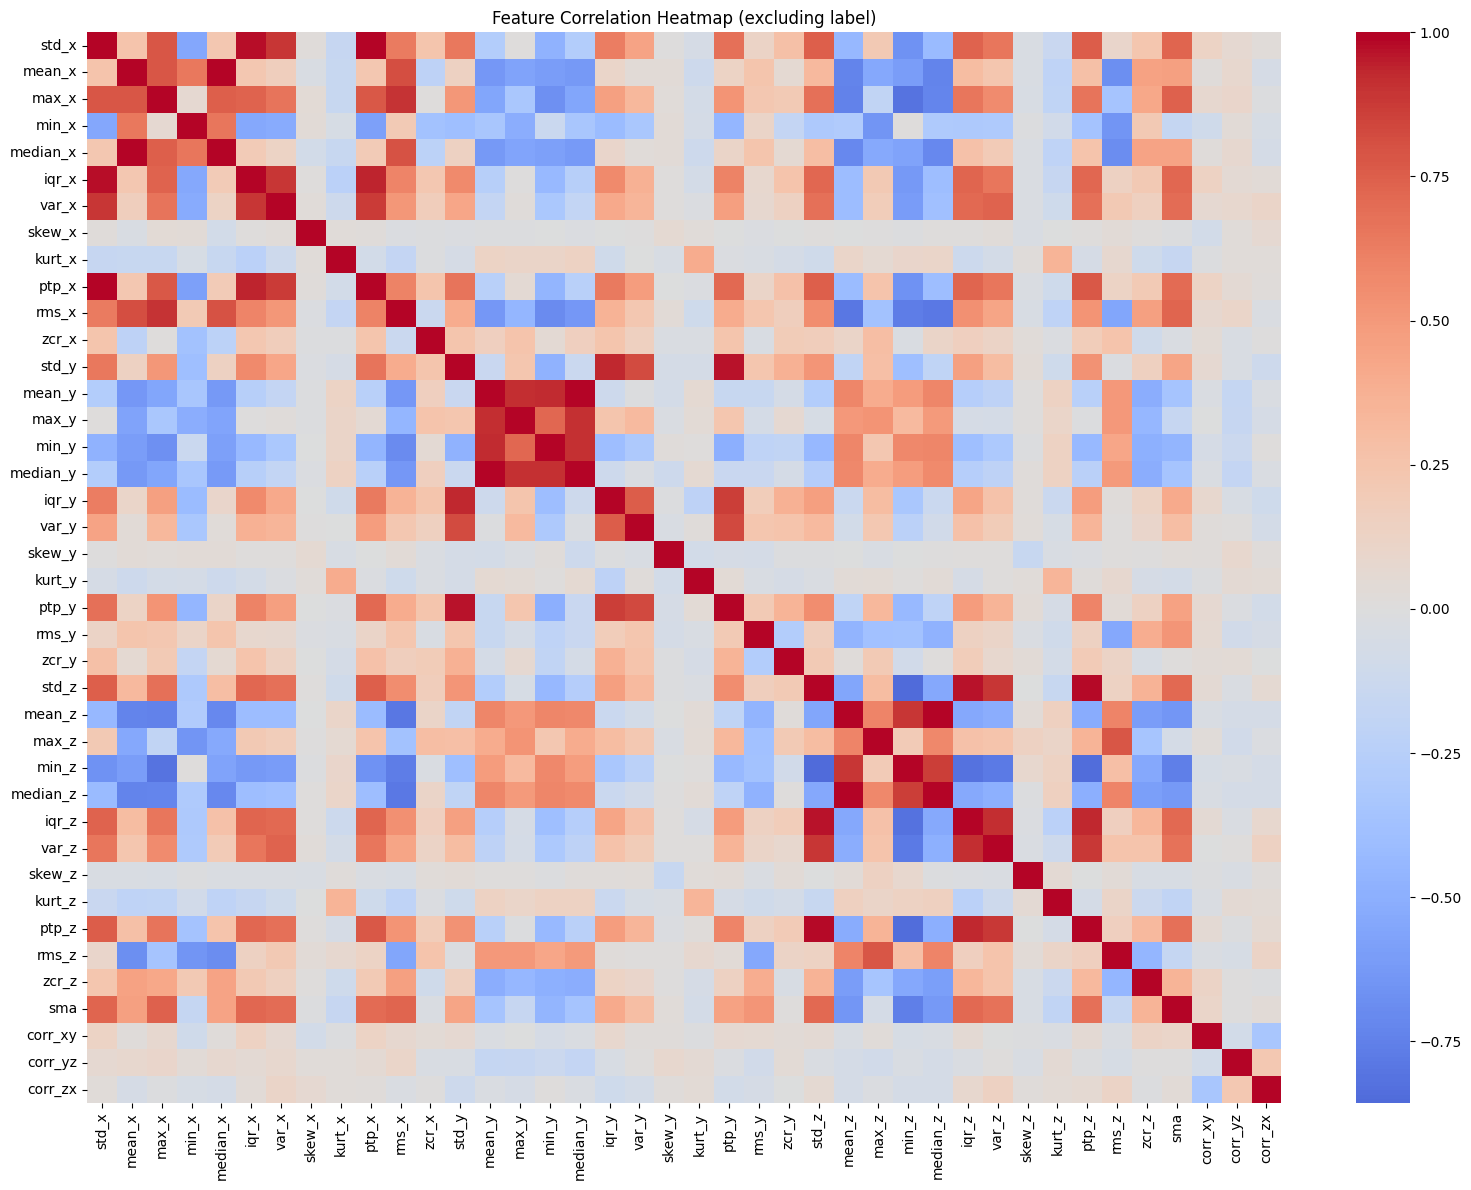

In [210]:
plot_corr(all_in_one_df)

We need to drop the belows:
- all corr_*
- all skew
- all kurt

In [ ]:
# drop_feats = ['skew', 'kurt']
# drop_cols = [f'{stat}_{axis}' for axis in ['x', 'y', 'z'] for stat in drop_feats]
# drop_cols += ['corr_xy', 'corr_yz', 'corr_zx']
# all_in_one_df.drop(columns=drop_cols, inplace=True)

In [211]:
all_in_one_df.shape

(31758, 41)

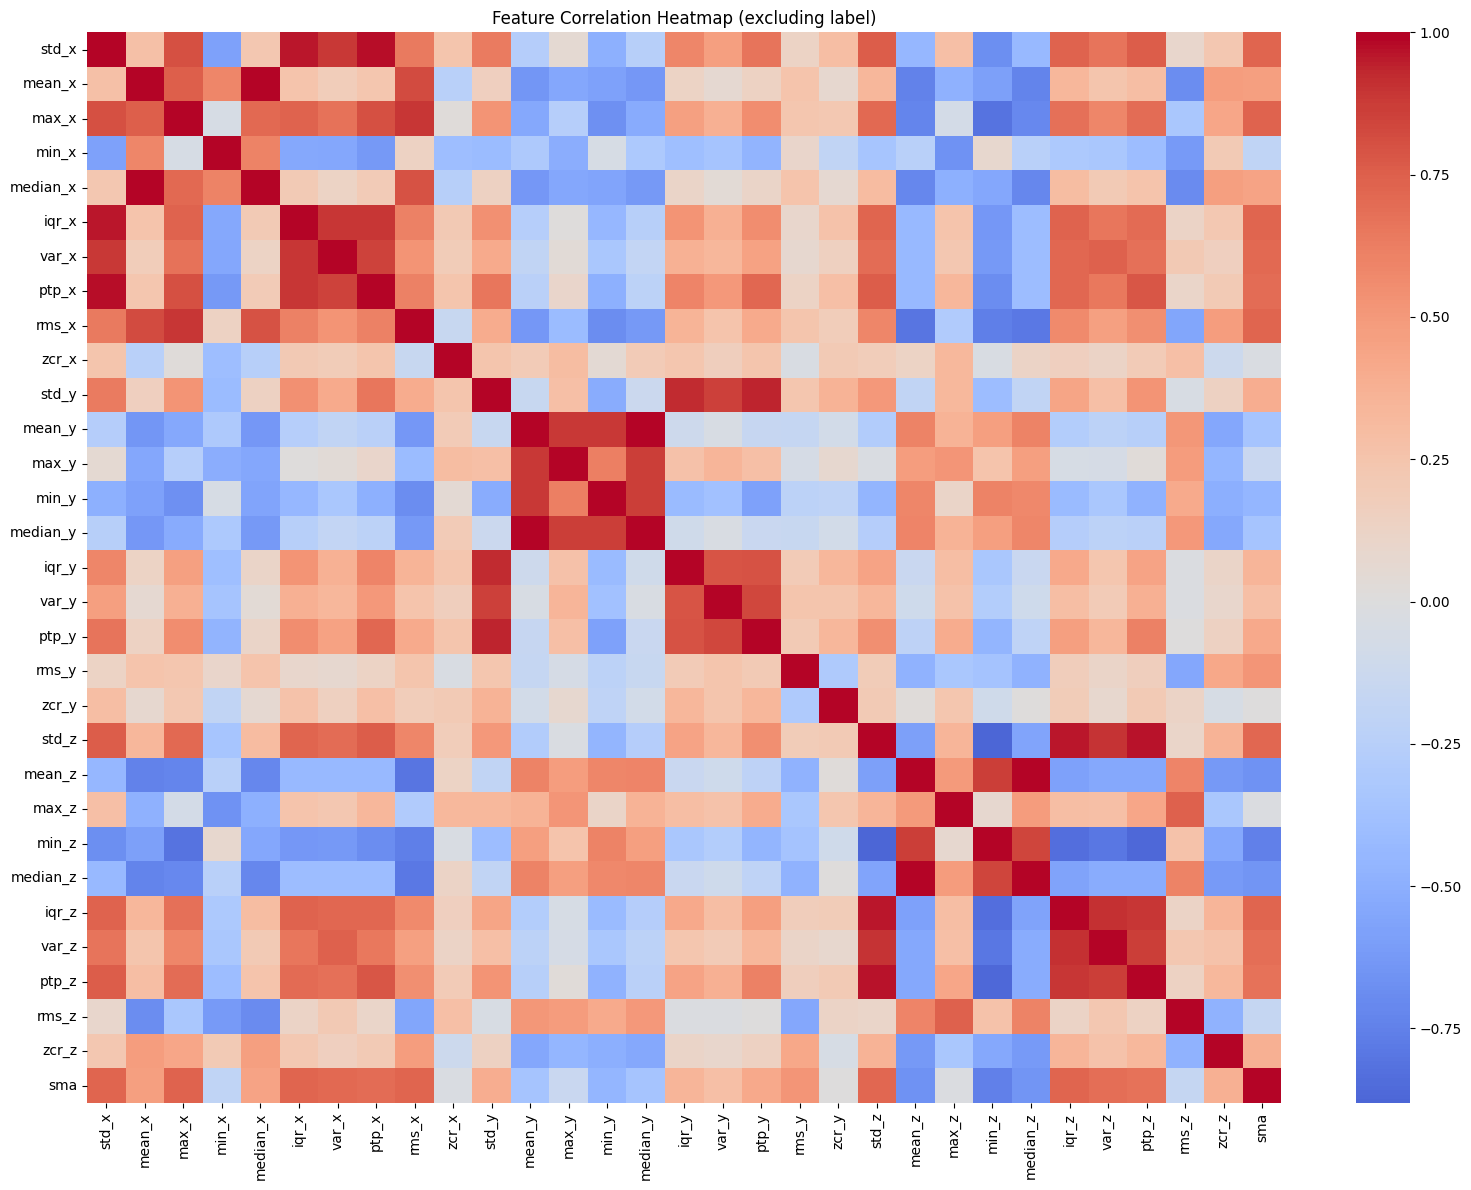

In [184]:
plot_corr(all_in_one_df)

In [ ]:
# print(len(seg_label_list))
# print(len(feats_list))
# features = ['std', 'mean', 'max', 'min', 'median', 'iqr', 'var', 'skew', 'kurt', 'ptp', 'rms', 'zcr']
# feats_cols = []
# for feat in features:
#     for axis in list(['x', 'y', 'z']):
#         feats_cols.append(feat + '_' + axis)
# feats_cols.extend(['sma', 'corr_xy', 'corr_yz', 'corr_zx'])
# feats_df = pd.DataFrame(feats_list, columns=feats_cols)
# corr_mtx = feats_df.corr()

In [118]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# max_iters = 40
# plt.figure(figsize=(30, 10))  # (width, height)

# sns.heatmap(corr_mtx.iloc[:max_iters,:max_iters], annot=True, cmap='coolwarm')
# plt.title('Feature Correlation Matrix')
# plt.show()

**features should be dropped**

max_y, max_z, min_z, meadian_z, var_y, var_z, skew_z, rms_y, rms_z

In [119]:
# feats_df2 = feats_df.copy()
# drop_cols = ['max_y', 'max_z', 'min_z', 'median_z', 'var_y', 'var_z', 'skew_z', 'rms_y', 'rms_z']
# feats_df2 = feats_df2.drop(columns=drop_cols)
# print(feats_df2.shape)
# feats_df2

## Correlation between features and label

In [21]:
# Now, I realized that it's meaningless to do this. Because the label is a category label even if we convert it to id, but the id is not even a linear correlation with other features.
# labels_df = pd.DataFrame(seg_label_list)
# combined_df = feats_df.join(labels_df)

In [22]:
# label_corr_mtx = combined_df.corr()

# Handling imbalanced data with different methods

In [39]:
# %pip install imblearn

In [40]:
# import numpy as np

# # convert to np array
# # X = np.array(feats_list)
# y = np.array(seg_label_list)

# # X = np.array(feats_df2)
# X = np.array(feats_list)

# print(f'X: {X.shape}, y: {y.shape}')

In [212]:
X = all_in_one_df.drop(columns=['label']).values
y = all_in_one_df['label'].values

## SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)

# X_resampled, y_resampled = smote.fit_resample(X, y)

# print(f'X: {X.shape}, y: {y.shape}')
# print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X: (31758, 31), y: (31758,)
X_resampled: (48690, 31), y_resampled: (48690,)


## Random Over Sampler

In [213]:
from imblearn.over_sampling import RandomOverSampler

randomSampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = randomSampler.fit_resample(X, y)

print(f'X: {X.shape}, y: {y.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X: (31758, 40), y: (31758,)
X_resampled: (48690, 40), y_resampled: (48690,)


## Split the data

In [161]:
def split_by_position(X, y, start_ratio=0.0, train_ratio=0.7):
    """
    Split dataset into train/test without shuffling.
    
    Parameters:
    - X, y: features and labels
    - start_ratio: float in [0, 1), where to start the 70% slice
    - train_ratio: proportion of the data to use as training (e.g. 0.7)

    Returns:
    - X_train, X_test, y_train, y_test
    """
    assert 0 <= start_ratio < 1, "start_ratio must be in [0, 1)"
    assert 0 < train_ratio <= 1, "train_ratio must be in (0, 1]"

    total_len = len(X)
    start_index = int(start_ratio * total_len)
    end_index = start_index + int(train_ratio * total_len)

    # Handle edge case where end_index exceeds total_len
    if end_index > total_len:
        end_index = total_len

    X_train = X[start_index:end_index]
    y_train = y[start_index:end_index]

    # Use everything else for test
    X_test = np.concatenate((X[:start_index], X[end_index:]), axis=0)
    y_test = np.concatenate((y[:start_index], y[end_index:]), axis=0)

    return X_train, X_test, y_train, y_test

In [ ]:
# X_train, X_test, y_train, y_test = split_by_position(X_resampled, y_resampled, start_ratio=0.3, train_ratio=0.7)

In [255]:
# split first 70/30 no shuffling

split_index = int(0.65 * len(X_resampled))

# Split without shuffling
X_train = X_resampled[:split_index]
X_test = X_resampled[split_index:]
y_train = y_resampled[:split_index]
y_test = y_resampled[split_index:]

print(f'X_train_shape: {X_train.shape}, X_test_shape: {X_test.shape}')
print(f'y_train_act_labels: {set(y_train.tolist())}\n y_test_act_labels: {set(y_test.tolist())}')

X_train_shape: (31648, 40), X_test_shape: (17042, 40)
y_train_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}
 y_test_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, random_state=32, stratify=y_resampled)

In [93]:
# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)
# y_train = np.array(y_train)

In [256]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")

X_train: (31648, 40), y_train: (31648,)
X_test : (17042, 40), y_test : (17042,)


## Standardize the features values

In [ ]:
# standardized the features values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training

## LabelSpreading

In [66]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report

kernel_list = ['rbf', 'knn']
max_iter_list = [50, 100, 200, 300, 1000]
for ker in kernel_list:
    for it in max_iter_list:
        lspred = LabelSpreading(kernel=ker, alpha=0.5, max_iter=it)
        lspred.fit(X_train, y_train)
        # predict
        y_predict = lspred.predict(X_test)
        print(classification_report(y_test, y_predict))


                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.19      0.88      0.32         8
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.00      0.00      0.00         8
         2 (FACING camera) both hands SHAKING (sitting position)       0.00      0.00      0.00         8
                 3 Stand up from chair - both hands with SHAKING       0.75      0.38      0.50         8
                                         4 (Sideway) Sit & stand       0.38      0.38      0.38         8
                        5 (Sideway) both hands SHAKING (sitting)       0.75      0.75      0.75         8
                  6 (Sideway) STAND up with - both hands SHAKING       0.43      0.38      0.40         8
                                     7 Cool down - sitting/relax       0.86      0.67      0.75         9
                                8 Walk (LEFT 

## RandomForest

In [166]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [257]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [258]:
from sklearn.metrics import classification_report

y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

        2806       0.95      0.80      0.87      2510
        2807       0.62      0.83      0.71      1317
        2808       0.84      0.79      0.81      1787
        2809       0.78      0.71      0.75      2145
        2810       0.78      0.75      0.76      1907
        2811       0.35      0.89      0.51      1077
        2812       0.88      0.43      0.58      3447
        2813       0.75      0.87      0.80      2619
        2814       0.51      0.98      0.67       123
        2815       0.95      0.36      0.53       110

    accuracy                           0.72     17042
   macro avg       0.74      0.74      0.70     17042
weighted avg       0.79      0.72      0.73     17042



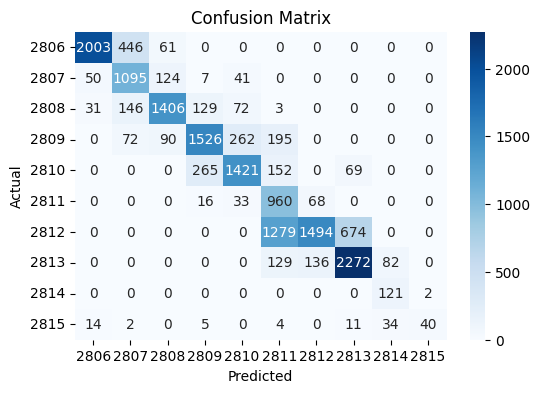

In [259]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# compute confusion matrix
cm = confusion_matrix(y_test, y_predict)
labels = np.unique(y_test)

# Plot with seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ExtraTreesClassifier

In [261]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1)

In [262]:
etc.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=500, n_jobs=-1)

In [263]:
from sklearn.metrics import classification_report

y_predict = etc.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

        2806       0.90      0.89      0.90      2510
        2807       0.65      0.84      0.73      1317
        2808       0.90      0.70      0.79      1787
        2809       0.76      0.78      0.77      2145
        2810       0.81      0.70      0.75      1907
        2811       0.32      0.92      0.47      1077
        2812       0.81      0.42      0.55      3447
        2813       0.84      0.79      0.82      2619
        2814       0.52      1.00      0.68       123
        2815       1.00      0.37      0.54       110

    accuracy                           0.72     17042
   macro avg       0.75      0.74      0.70     17042
weighted avg       0.79      0.72      0.73     17042



### Machine learning algorithms evaluation
Prerequisites:
1. No dropping any features
Summary:
- ExtraTreesClassifier gives the most stable and highest f1-score

# Deep Learning

## Convert to tensor

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [131]:
# Pastikan input adalah float dan label adalah integer
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

# Encode label ke 0-9 jika belum
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [132]:
y_test_tensor.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [103]:
y_train_tensor

tensor([9, 9, 6,  ..., 8, 3, 3])

In [104]:
print(f'X_train_tensor: {X_train_tensor.shape}, y_train_tensor: {y_train_tensor.shape}')

X_train_tensor: torch.Size([34083, 40, 1]), y_train_tensor: torch.Size([34083])


In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## LSTM

In [137]:
class DeepBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=10, dropout=0.3):
        super(DeepBiLSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size * 4),  # *2 karena bidirectional
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size * 2, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # output: (batch, seq_len, hidden*2)
        out = lstm_out[:, -1, :]    # Ambil output timestep terakhir
        return self.mlp(out)

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepBiLSTMClassifier(
            input_size=X_train_tensor.shape[2],  # atau 12
            hidden_size=32,
            num_layers=2,
            num_classes=10,
            dropout=0.35
        ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/1000, Loss: 2.3139
Epoch 1/1000, Loss: 2.3250
Epoch 1/1000, Loss: 2.2995
Epoch 1/1000, Loss: 2.3141
Epoch 1/1000, Loss: 2.3116
Epoch 1/1000, Loss: 2.3076
Epoch 1/1000, Loss: 2.3136
Epoch 1/1000, Loss: 2.3020
Epoch 1/1000, Loss: 2.2946
Epoch 1/1000, Loss: 2.2942
Epoch 1/1000, Loss: 2.3067
Epoch 1/1000, Loss: 2.3096
Epoch 1/1000, Loss: 2.3200
Epoch 1/1000, Loss: 2.3026
Epoch 1/1000, Loss: 2.3174
Epoch 1/1000, Loss: 2.3096
Epoch 1/1000, Loss: 2.3037
Epoch 1/1000, Loss: 2.2983
Epoch 1/1000, Loss: 2.3004
Epoch 1/1000, Loss: 2.3121
Epoch 1/1000, Loss: 2.2974
Epoch 1/1000, Loss: 2.3020
Epoch 1/1000, Loss: 2.3027
Epoch 1/1000, Loss: 2.3023
Epoch 1/1000, Loss: 2.2962
Epoch 1/1000, Loss: 2.3020
Epoch 1/1000, Loss: 2.3085
Epoch 1/1000, Loss: 2.3093
Epoch 1/1000, Loss: 2.3046
Epoch 1/1000, Loss: 2.3046
Epoch 1/1000, Loss: 2.3152
Epoch 1/1000, Loss: 2.3054
Epoch 1/1000, Loss: 2.2942
Epoch 1/1000, Loss: 2.2981
Epoch 1/1000, Loss: 2.3282
Epoch 1/1000, Loss: 2.3066
Epoch 1/1000, Loss: 2.3064
E

KeyboardInterrupt: 

In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

all_classes = list(range(10))  # 0-9
print(classification_report(
    all_targets,
    all_preds,
    labels=all_classes,
    target_names=[f"Class {i}" for i in all_classes],
    zero_division=0
))

              precision    recall  f1-score   support

     Class 0       0.05      0.33      0.08         3
     Class 1       0.31      1.00      0.48         5
     Class 2       0.10      0.14      0.12         7
     Class 3       0.00      0.00      0.00         4
     Class 4       0.00      0.00      0.00         9
     Class 5       0.00      0.00      0.00         8
     Class 6       0.20      0.29      0.24         7
     Class 7       0.00      0.00      0.00         3
     Class 8       0.00      0.00      0.00         5
     Class 9       0.00      0.00      0.00         9

    accuracy                           0.15        60
   macro avg       0.07      0.18      0.09        60
weighted avg       0.06      0.15      0.08        60



## Transformer

In [135]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_layers=2, num_classes=10, dropout=0.25):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model*4),
            nn.Dropout(0.2),
            nn.GELU(),
            
            nn.LayerNorm(d_model*4),
            nn.Linear(d_model*4, d_model),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim) → (16, 12, 1)
        x = self.input_projection(x)       # → (16, 12, d_model)
        x = self.pos_encoder(x)            # positional encoding
        x = x.transpose(0, 1)              # → (seq_len, batch, d_model)
        x = self.transformer_encoder(x)    # → (seq_len, batch, d_model)
        x = x.mean(dim=0)                  # mean pooling over time steps → (batch, d_model)
        return self.classifier(x)          # → (batch, num_classes)

In [136]:
from torch.optim.lr_scheduler import OneCycleLR

model = TransformerClassifier(
            input_dim=1, 
            d_model=256, 
            nhead=16, 
            num_layers=2, 
            num_classes=10,
            dropout=0.2
        ).to(device)

num_epochs = 200
max_lr = 0.001
clip_value = 3
steps_per_epoch = len(train_loader)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr)


scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.1,  # % of total steps to increase the LR
    anneal_strategy='cos',  # cosine annealing after max_lr
    div_factor=10.0,  # initial_lr = max_lr / div_factor
    final_div_factor=100  # final_lr = initial_lr / final_div_factor
)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()  # Step the OneCycle scheduler
        print(scheduler.get_last_lr())


        running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / steps_per_epoch:.4f}")

/Users/tptn/MachineLearning/tremor_challenge2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[0.00010000001954561485]
Epoch 1/200, Loss: 0.0044
[0.00010000007818245752]
Epoch 1/200, Loss: 0.0088
[0.00010000017591052317]
Epoch 1/200, Loss: 0.0132
[0.00010000031272980315]
Epoch 1/200, Loss: 0.0176
[0.00010000048864028561]
Epoch 1/200, Loss: 0.0219
[0.00010000070364195519]
Epoch 1/200, Loss: 0.0263
[0.00010000095773479332]
Epoch 1/200, Loss: 0.0305
[0.00010000125091877779]
Epoch 1/200, Loss: 0.0348
[0.00010000158319388344]
Epoch 1/200, Loss: 0.0391
[0.000100001954560081]
Epoch 1/200, Loss: 0.0434
[0.00010000236501733837]
Epoch 1/200, Loss: 0.0477
[0.00010000281456562011]
Epoch 1/200, Loss: 0.0519
[0.00010000330320488685]
Epoch 1/200, Loss: 0.0562
[0.00010000383093509643]
Epoch 1/200, Loss: 0.0607
[0.00010000439775620265]
Epoch 1/200, Loss: 0.0650
[0.00010000500366815661]
Epoch 1/200, Loss: 0.0693
[0.00010000564867090542]
Epoch 1/200, Loss: 0.0734
[0.00010000633276439333]
Epoch 1/200, Loss: 0.0776
[0.00010000705594856072]
Epoch 1/200, Loss: 0.0818
[0.00010000781822334481]
Epoch 1/

KeyboardInterrupt: 

In [68]:
y_batch

tensor([2, 5, 6, 5, 0, 6, 0, 2, 4, 9, 7, 2, 4, 0, 6, 6, 5, 3, 3, 4, 9, 5, 2, 8,
        4, 4, 0, 0, 6, 2, 4, 1])

In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

all_classes = list(range(10))  # 0-9
print(classification_report(
    all_targets,
    all_preds,
    labels=all_classes,
    target_names=[f"Class {i}" for i in all_classes],
    zero_division=0
))

              precision    recall  f1-score   support

     Class 0       0.17      0.25      0.20         8
     Class 1       1.00      0.50      0.67         8
     Class 2       0.25      0.12      0.17         8
     Class 3       0.75      0.38      0.50         8
     Class 4       0.38      0.38      0.38         8
     Class 5       0.17      0.12      0.14         8
     Class 6       0.33      0.38      0.35         8
     Class 7       0.42      0.56      0.48         9
     Class 8       0.38      0.62      0.48         8
     Class 9       0.33      0.38      0.35         8

    accuracy                           0.37        81
   macro avg       0.42      0.37      0.37        81
weighted avg       0.42      0.37      0.37        81



# Experimenting with Lazy Predict

In [91]:
# %pip install lazypredict
# %pip install ipywidgets

In [264]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9870
[LightGBM] [Info] Number of data points in the train set: 31648, number of used features: 40
[LightGBM] [Info] Start training from score -2.596437
[LightGBM] [Info] Start training from score -2.187164
[LightGBM] [Info] Start training from score -2.329096
[LightGBM] [Info] Start training from score -2.452574
[LightGBM] [Info] Start training from score -2.368810
[LightGBM] [Info] Start training from score -2.121781
[LightGBM] [Info] Start training from score -3.102611
[LightGBM] [Info] Start training from score -2.643745
[LightGBM] [Info] Start training from score -1.897373
[LightGBM] [Info] Start training from score -1.894637
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                      